In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 2922, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 2922 (delta 359), reused 499 (delta 339), pack-reused 2390
Receiving objects: 100% (2922/2922), 40.28 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (1854/1854), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
! pip install --upgrade polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.15
    Uninstalling polars-0.20.15:
      Successfully uninstalled polars-0.20.15


In [4]:
! pip install simsimd scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.2/382.2 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import (
    _preprocessing_history_trendiness_scores, 
    add_history_trendiness_scores_feature, 
    _preprocessing_mean_delay_features, 
    add_mean_delays_features, 
    _preprocessing_window_features, 
    add_window_features, 
    add_trendiness_feature_categories, 
    _preprocessing_article_endorsement_feature, 
    get_unique_categories,
    add_trendiness_feature
)

from catboost import CatBoostRanker

2024-05-12 20:27:17.653910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 20:27:17.654107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 20:27:17.858059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Memory Utils

In [6]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.8665


In [7]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [8]:
articles = pl.read_parquet('/kaggle/input/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 1.125


# Articles Preprocessing

In [9]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
    # very important for tf-idf, otherwise multiple tokens for topics with spaces are built
    pl.col('topics').list.eval(pl.element().str.split(by=' ').list.join('_')),
    pl.col('topics').list.len().alias('num_topics'),
    (pl.col('total_pageviews') / pl.col('total_inviews')).alias('total_pageviews/inviews')
)
articles = reduce_polars_df_memory_size(articles)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)

Memory usage of dataframe is 58.23 MB
Memory usage after optimization is: 58.00 MB
Decreased by 0.4%

RAM memory GB usage = 1.13


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null


In [10]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['MISC', 'PROD', 'EVENT', 'PER', 'LOC', 'ORG']

In [11]:
# in case of two category_str for the same category, one of the two is picked
unique_categories_df = articles.select(['category', 'category_str']).unique('category').drop_nulls('category')
unique_categories = {
    row['category']: row['category_str'] for row in unique_categories_df.iter_rows(named=True)
}
unique_categories

{572: 'side9',
 140: 'krimi',
 539: 'ferie',
 2504: 'bibliotek',
 414: 'underholdning',
 2975: 'penge',
 1505: 'vin',
 2731: 'dagsorden',
 2341: 'plus',
 498: 'musik',
 561: 'haandvaerkeren',
 22: 'horoskoper',
 2889: 'auto',
 457: 'forbrug',
 2737: 'podcast',
 118: 'nyheder',
 806: 'om_ekstra_bladet',
 731: 'services',
 529: 'biler',
 142: 'sport',
 2: 'incoming',
 2077: 'opinionen',
 68: 'video',
 512: 'nationen',
 565: 'sex_og_samliv'}

Mapping sentiment labels to -1, 0, 1 to save memory in the history dataframe.
Taking only article_default type and mapping it to 0/1 since after only this is needed (and it saves memory) for the history at the moment

In [12]:
articles = articles.with_columns(
    pl.when(pl.col('sentiment_label') == 'Negative').then(-1) \
        .otherwise(
            pl.when(pl.col('sentiment_label') == 'Positive').then(1).otherwise(0)
        ).cast(pl.Int8).alias('sentiment_label_int'),
    (pl.col('article_type') == 'article_default').cast(pl.UInt8).alias('is_article_default')
)

## Topics TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray().astype(np.float32)
    ).alias('topics_idf')
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)


RAM memory GB usage = 1.145


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32]
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]"


In [14]:
# without split + join with _ of the single topics this returns 94
len(vectorizer.get_feature_names_out())

79

## Topic Model

In [15]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('danish')
title_vectorizer = CountVectorizer(stop_words=stopwords)

titles_bow = title_vectorizer.fit_transform(articles['title'].to_list())

In [16]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

# parameters tuned on perplexity
N_COMPONENTS = 5
lda_model = LatentDirichletAllocation(
    n_components=N_COMPONENTS,
    doc_topic_prior=0.99,
    topic_word_prior=0.75,
    learning_method='online'
)
articles = articles.with_columns(
    pl.Series(lda_model.fit_transform(titles_bow).astype(np.float32)) \
        .list.to_array(5).alias('topic_model_embeddings')
)
articles.head(2)

CPU times: user 37.9 s, sys: 0 ns, total: 37.9 s
Wall time: 37.9 s


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embeddings
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],"array[f32, 5]"
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]","[0.143597, 0.143761, … 0.281231]"
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]","[0.17063, 0.478226, … 0.117905]"


In [17]:
topic_model_columns = [f'topic_model_embedding_{i}' for i in range(N_COMPONENTS)]

articles = articles.with_columns(
    pl.col('topic_model_embeddings').arr.to_struct(fields=lambda i: f'topic_model_embedding_{i}')
).with_columns([
    pl.col('topic_model_embeddings').struct.field(f'topic_model_embedding_{i}') for i in range(N_COMPONENTS)
]).drop('topic_model_embeddings')

articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embedding_0,topic_model_embedding_1,topic_model_embedding_2,topic_model_embedding_3,topic_model_embedding_4
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],f32,f32,f32,f32,f32
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]",0.143597,0.143761,0.143682,0.287729,0.281231
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]",0.17063,0.478226,0.124377,0.108861,0.117905


# History preprocessing

In [18]:
def add_topics_tf_idf_columns(df, topics_col, vectorizer):
    return df.with_columns(
        pl.Series(
            vectorizer.transform(
                df.with_columns(pl.col(topics_col).list.join(separator=' '))[topics_col].to_list()
            ).toarray().astype(np.float32)
        ).alias(f'{topics_col}_tf_idf')
    )

In [19]:
%%time

STRONG_THR = 0.8

history_train = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_train.iter_slices(1000), total=history_train.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_train = reduce_polars_df_memory_size(history_train)
history_train.head(2)

16it [00:17,  1.10s/it]                        



RAM memory GB usage = 1.297
Memory usage of dataframe is 39.39 MB
Memory usage after optimization is: 38.61 MB
Decreased by 2.0%
CPU times: user 20.8 s, sys: 1.73 s, total: 22.5 s
Wall time: 18.3 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,MISCPct,PRODPct,EVENTPct,PERPct,LOCPct,ORGPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9739035, 9739065, … 9770533]","[2023-04-27 14:29:44, 2023-04-27 14:29:47, … 2023-05-17 17:36:24]","[118, 414, … 140]",143,3.0,1563.0,9623.0,42.5,100.0,0.230769,0.111888,0.657343,0.097902,0.083916,0.608392,0.06993,118,1,18,"[0.016041, 0.062928, … 0.178427]",0.223776,0.237762,0.202797,0.874126,0.804196,0.888112
12016,"[9738216, 9735383, … 9769622]","[2023-04-27 07:39:48, 2023-04-27 07:41:30, … 2023-05-17 23:56:30]","[140, 118, … 140]",264,156.0,1775.0,63672.0,100.0,100.0,0.257576,0.075758,0.666667,0.106061,0.034091,0.602273,0.07197,140,5,20,"[0.009749, 0.045896, … 0.075912]",0.117424,0.318182,0.087121,0.787879,0.776515,0.852273


In [20]:
history_train.shape

(15143, 27)

# Named entity collaborative filtering

In [21]:
user_id_mapping = history_train.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_mapping = articles.select(['ner_clusters']) \
    .explode('ner_clusters') \
    .rename({'ner_clusters': 'ner'}) \
    .with_columns(pl.col('ner').str.strip_chars_start('\" ').str.to_lowercase()) \
    .unique('ner').drop_nulls().filter(pl.col('ner').str.len_chars() > 0) \
    .sort('ner').with_row_index().rename({'index': 'ner_index'})

In [22]:
ner_interactions = history_train.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_train.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [23]:
%cd /kaggle/working
! git clone https://github.com/MaurizioFD/RecSys_Course_AT_PoliMi.git

/kaggle/working


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'RecSys_Course_AT_PoliMi'...
remote: Enumerating objects: 1519, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1519 (delta 223), reused 220 (delta 212), pack-reused 1264
Receiving objects: 100% (1519/1519), 50.33 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (909/909), done.


In [24]:
%cd /kaggle/working/RecSys_Course_AT_PoliMi

from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Evaluation.Evaluator import EvaluatorHoldout

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

/kaggle/working/RecSys_Course_AT_PoliMi
ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 18909 (43.2%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 156.32 column/sec. Elapsed time 4.67 min
EvaluatorHoldout: Ignoring 31 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15112 (100.0%) in 44.54 sec. Users per second: 339


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.311971,0.312913,0.030088,0.214433,0.214676,0.469902,0.319612,0.054883,0.766609,0.953152,...,0.997953,0.76504,0.997953,0.002086,5.362616,0.952586,0.016842,0.419597,3.357942,0.009295


In [25]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 1 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 18909 (43.2%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.91 sec
EvaluatorHoldout: Processed 15112 (100.0%) in 23.34 sec. Users per second: 648


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.342628,0.345141,0.048661,0.261759,0.263204,0.670397,0.392258,0.085219,0.858655,1.275579,...,0.997953,0.856898,0.997953,0.001871,5.929536,0.95823,0.015104,0.463956,3.324192,0.009294


In [26]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_train.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_train.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).max().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 4min 32s, sys: 3min 11s, total: 7min 44s
Wall time: 2min 6s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
99370267,9769917,0.502234,0.452011,0.596171,0.596403,0.536763,0.740626
519927717,9777648,0.066605,0.104665,0.282093,0.276504,0.474006,0.54859
524649090,9771242,0.305414,1.0,0.540999,0.582527,1.0,1.0
255654986,9772045,0.0316,0.064352,0.157114,0.019417,0.04257,0.076613
367380150,9494434,0.472486,0.228321,0.38683,0.212653,0.187066,0.333612


In [27]:
del URM_ner
del URM_ner_test
del ner_inview_scores
del ner_interactions
del ner_interactions_test
gc.collect()

0

# Creating Training Dataframe

In [28]:
def normalize_endorsement(articles_endorsement_raw):
    return articles_endorsement.sort(by='impression_time').with_columns(
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').sum().over('impression_time')
        ).alias('normalized_endorsement_10h'),
        (
            pl.col('endorsement_10h') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_10h_diff_rolling'),
        (
            pl.col('endorsement_10h').rolling_mean(5, min_periods=1).over('article') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_macd'),
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').quantile(0.8).over('impression_time')
        ).alias('endorsement_quantile_norm_10h')
    ).with_columns(
        (
            pl.col('normalized_endorsement_10h') / 
            pl.col('normalized_endorsement_10h').rolling_max(10, min_periods=1).over('impression_time')
        ).alias('normalized_endorsement_10h_rolling_max_ratio'),
    )
    

def add_article_endorsement_feature(df_features, normalized_endorsement):
    # old return df_features.join(other=articles_endorsement, on=["article", "impression_time"], how="left")
    normalized_endorsement = normalized_endorsement.with_columns(pl.col('article').cast(pl.Int32))
    return df_features.with_columns(pl.col('impression_time').dt.round('1m').alias('rounded_impression_time'))\
                         .join(normalized_endorsement.rename({'impression_time' : 'rounded_impression_time'}), on=['article','rounded_impression_time'], how='left')\
                         .drop('rounded_impression_time')

In [29]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_train, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_train)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_train, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_train, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)

topics = articles.select("topics").explode("topics").unique()
topics = [topic for topic in topics["topics"] if topic is not None]

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .with_columns(pl.col('postcode').fill_null(5)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 
                            'total_pageviews/inviews', 'article_type']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours'),
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

train_ds = reduce_polars_df_memory_size(train_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head()

16it [00:28,  1.77s/it]                        
2427it [00:06, 384.99it/s]                          
16it [00:01,  8.46it/s]                        
16it [00:02,  7.15it/s]                        
100%|██████████| 506/506 [00:03<00:00, 127.06it/s]



RAM memory GB usage = 2.691
Memory usage of dataframe is 853.28 MB
Memory usage after optimization is: 535.17 MB
Decreased by 37.3%

RAM memory GB usage = 2.381
CPU times: user 10min 5s, sys: 46 s, total: 10min 51s
Wall time: 3min 10s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,session_id,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PROD_Present,Entity_EVENT_Present,Entity_PER_Present,Entity_LOC_Present,Entity_ORG_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,u32,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32
327023671,9779860,1058825,2023-05-25 05:13:22,0,1,18.0,null,false,2,null,false,1833217,5,54,151,222,4,5,0.357616,0.243243,0.275547,false,2023-05-24 20:23:45,118,0.9862,"""Negative""",0,7,17,273,4,216059,978794,1.1436902e7,0.22074,"""article_default""",0,8,true,false,false,true,true,true,1.0,1.0,1.0,1.0,1.0,1.0,231.512817,184.012833,3.607758,89.122955,215.948715,5186.871582,39,0,0,17,1,0,0,1,19,32,109,3309,0.035791,59.5,33.900002,2.16416,1.0
568167788,9770333,1924926,2023-05-18 20:54:50,0,2,25.0,null,false,2,null,false,107170,5,141,409,745,4,20,0.344743,0.189262,0.794175,false,2023-05-17 14:37:52,142,0.9453,"""Positive""",4,6,19,490,5,142866,546957,1.2300924e7,0.261202,"""article_default""",1,30,true,false,false,true,true,false,1.0,1.0,0.981059,0.802751,0.676459,0.461218,215.289154,390.059143,3.625412,89.494057,6.891566,166.819275,31,37,38,11,0,0,1,0,15,56,110,29,0.000286,2.3,0.9,0.012304,0.006392
529279290,9566633,2142415,2023-05-20 12:13:53,0,1,90.0,100.0,false,2,null,false,301327,5,71,209,343,6,12,0.339713,0.206997,0.413861,true,2023-01-03 10:58:46,414,0.6784,"""Positive""",16,8,17,1030,3,null,null,null,null,"""article_default""",137,3289,false,true,true,true,true,true,0.783578,0.087064,0.381056,0.67125,0.074583,0.390421,245.398178,293.239532,15.11193,365.576935,0.723404,19.136778,176,124,54,32,1,1,0,0,24,95,53,187,0.002145,48.299999,27.5,0.084007,0.109229
226615407,9766721,1307252,2023-05-19 06:38:32,0,2,25.0,null,false,2,null,false,1390457,5,37,128,193,5,6,0.2890625,0.19171,0.20813,true,2023-05-15 18:06:20,140,0.9797,"""Negative""",9,9,31,1268,3,38888,780177,2.810159e6,0.049845,"""article_default""",3,84,false,false,false,true,true,true,0.126829,0.247114,0.682814,0.117684,0.205275,0.720031,230.63588,151.721191,6.687091,162.839218,2.21492,55.287743,311,175,71,112,1,0,0,0,49,122,62,746,0.006686,40.400002,21.6,0.395756,0.267767
71566504,9772193,705487,2023-05-19 09:40:16,0,1,9.0,null,false,2,null,false,1744242,5,45,217,333,5,9,0.207373,0.135135,0.352846,false,2023-05-19 07:30:38,2975,0.9881,"""Negative""",0,7,25,175,4,119701,421449,5.786008e6,0.284023,"""article_default""",0,2,false,false,false,false,false,true,-0.005131,-0.01703,-0.000088,0.015463,0.055569,0.04325,247.285721,316.556976,5.383747,131.56778,0.0,0.428571,7,0,0,0,1,0,0,0,0,10,15,1406,0.019402,25.4,18.200001,0.852638,0.45093


In [30]:
train_ds.shape

(2585747, 74)

## Session Features

In [31]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration', 
              'all_seen_articles', 'mean_prev_sessions_duration'])
    
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
last_session_time_df.head(2)


RAM memory GB usage = 2.355
CPU times: user 1.69 s, sys: 118 ms, total: 1.81 s
Wall time: 1.31 s


session_id,last_session_time,last_session_duration,all_seen_articles,mean_prev_sessions_duration
u32,datetime[μs],i64,list[i32],f64
695286,2023-05-17 13:15:13,0,[9767534],0.0
791083,2023-05-18 06:42:32,0,[9735909],0.0


In [32]:
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time'])

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)


RAM memory GB usage = 2.71


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,Entity_PER_Present,Entity_LOC_Present,Entity_ORG_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i64,f64,i64,bool,bool
327023671,9779860,1058825,2023-05-25 05:13:22,0,1,18.0,null,false,2,null,false,5,54,151,222,4,5,0.357616,0.243243,0.275547,false,118,0.9862,"""Negative""",0,7,17,273,4,216059,978794,1.1436902e7,0.22074,"""article_default""",0,8,…,true,true,true,1.0,1.0,1.0,1.0,1.0,1.0,231.512817,184.012833,3.607758,89.122955,215.948715,5186.871582,39,0,0,17,1,0,0,1,19,32,109,3309,0.035791,59.5,33.900002,2.16416,1.0,0,1.0,212,false,false
568167788,9770333,1924926,2023-05-18 20:54:50,0,2,25.0,null,false,2,null,false,5,141,409,745,4,20,0.344743,0.189262,0.794175,false,142,0.9453,"""Positive""",4,6,19,490,5,142866,546957,1.2300924e7,0.261202,"""article_default""",1,30,…,true,true,false,1.0,1.0,0.981059,0.802751,0.676459,0.461218,215.289154,390.059143,3.625412,89.494057,6.891566,166.819275,31,37,38,11,0,0,1,0,15,56,110,29,0.000286,2.3,0.9,0.012304,0.006392,1,1.4375,-62,true,false


In [33]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.558189,0.023648


In [34]:
del last_history_df
del last_session_time_df
gc.collect()

0

## Popularities

In [35]:
%%time

articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds = reduce_polars_df_memory_size(train_ds)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

Memory usage of dataframe is 575.55 MB
Memory usage after optimization is: 523.46 MB
Decreased by 9.1%

RAM memory GB usage = 2.716
CPU times: user 2.24 s, sys: 1.22 s, total: 3.46 s
Wall time: 2.95 s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,Entity_LOC_Present,Entity_ORG_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
327023671,9779860,1058825,2023-05-24,0,1,18.0,null,false,2,null,false,5,54,151,222,4,5,0.357616,0.243243,0.275547,false,118,0.9862,"""Negative""",0,7,17,273,4,216059,978794,1.1436902e7,0.22074,"""article_default""",0,8,…,true,true,1.0,1.0,1.0,1.0,1.0,1.0,231.512817,184.012833,3.607758,89.122955,215.948715,5186.871582,39,0,0,17,1,0,0,1,19,32,109,3309,0.035791,59.5,33.900002,2.16416,1.0,0,1.0,212,false,false,0.239437
568167788,9770333,1924926,2023-05-17,0,2,25.0,null,false,2,null,false,5,141,409,745,4,20,0.344743,0.189262,0.794175,false,142,0.9453,"""Positive""",4,6,19,490,5,142866,546957,1.2300924e7,0.261202,"""article_default""",1,30,…,true,false,1.0,1.0,0.981059,0.802751,0.676459,0.461218,215.289154,390.059143,3.625412,89.494057,6.891566,166.819275,31,37,38,11,0,0,1,0,15,56,110,29,0.000286,2.3,0.9,0.012304,0.006392,1,1.4375,-62,true,false,0.301587


# Adding history features

In [36]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


def list_pct_matches_with_constant(a, value) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with a constant value.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise(pl.col(a).list.count_matches(value) / pl.col(a).list.len())


def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0


prev_train_columns = [c for c in train_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

train_ds = pl.concat(
    rows.join(history_train.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_train.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(train_ds.iter_slices(10000), total=train_ds.shape[0] // 10000)
)
train_ds = reduce_polars_df_memory_size(train_ds)

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

259it [39:20,  9.11s/it]


Memory usage of dataframe is 1574.88 MB
Memory usage after optimization is: 1192.66 MB
Decreased by 24.3%

RAM memory GB usage = 5.314


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,Entity_MISC_Present,…,MostFrequentWeekday,MostFrequentHour,MISCPct,PRODPct,EVENTPct,PERPct,LOCPct,ORGPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_side9_Pct,Category_krimi_Pct,Category_ferie_Pct,Category_bibliotek_Pct,Category_underholdning_Pct,Category_penge_Pct,Category_vin_Pct,Category_dagsorden_Pct,Category_plus_Pct,Category_musik_Pct,Category_haandvaerkeren_Pct,Category_horoskoper_Pct,Category_auto_Pct,Category_forbrug_Pct,Category_podcast_Pct,Category_nyheder_Pct,Category_om_ekstra_bladet_Pct,Category_services_Pct,Category_biler_Pct,Category_sport_Pct,Category_incoming_Pct,Category_opinionen_Pct,Category_video_Pct,Category_nationen_Pct,Category_sex_og_samliv_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
564406454,9773617,58165,0,1,62.0,null,false,2,null,false,5,96,286,466,6,18,0.335664,0.206009,0.566337,false,142,0.5776,"""Positive""",1,9,17,259,4,15595,190784,729997.0,0.081742,"""article_default""",0,4,true,…,2,19,0.184466,0.339806,0.196602,0.88835,0.803398,0.915049,0.163632,false,10,0.978155,0.0,0.114078,0.004854,0.0,0.257282,0.014563,0.0,0.0,0.0,0.058252,0.0,0.0,0.0,0.036408,0.0,0.349515,0.0,0.0,0.002427,0.133495,0.0,0.0,0.0,0.029126,0.0
377510594,9771796,183388,1,2,60.0,null,false,2,null,false,5,92,293,478,5,6,0.313993,0.192469,0.476423,false,498,0.991,"""Negative""",2,2,28,220,5,143987,636364,6.660941e6,0.226265,"""article_default""",0,11,false,…,7,6,0.125,0.125,0.25,0.875,0.875,0.875,0.389439,false,5,0.375,0.0,0.375,0.0,0.0,0.25,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0


In [37]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'article_delay_hours', 'total_pageviews',
    'total_inviews', 'trendiness_score_category', 'std_JS', 'trendiness_score_5d', 'total_read_time'
]
RANK_IMPRESSION_DESCENDING = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'total_pageviews', 'total_read_time',
    'total_inviews', 'trendiness_score_category', 'trendiness_score_5d'
]
RANK_IMPRESSION_ASCENDING = [
    'article_delay_hours', 'std_JS', 'mean_topics_mean_delay_hours'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
LIST_DIVERSITY = [
    'category', 'sentiment_label', 'article_type'
]

train_ds = train_ds.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).rank(method='min').over(pl.col('impression_id')).alias(f'{c}_rank_impression')
      for c in RANK_IMPRESSION_ASCENDING],
    *[pl.col(c).rank(method='min', descending=True).over(pl.col('impression_id')).alias(f'{c}_rank_impression')
      for c in RANK_IMPRESSION_DESCENDING],
    *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).entropy().over(pl.col('impression_id')).alias(f'entropy_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) - pl.col(c).median().over(pl.col('impression_id'))).alias(f'{c}_minus_median_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
      for c in NORMALIZE_OVER_USER_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
      for c in NORMALIZE_OVER_ARTICLE],
    *[pl.col(c).n_unique().over('impression_id').alias(f'{c}_diversity_impression')
      for c in LIST_DIVERSITY],
)

# Training

In [38]:
train_ds = train_ds.drop(['article', 'user_id']).to_pandas().sort_values(by='impression_id')
groups = train_ds['impression_id'].copy()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory',
                       'article_type', 'postcode']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target', 'impression_id'])
y = train_ds['target']

In [39]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 6.513


In [40]:
model = CatBoostRanker(cat_features=categorical_columns, iterations=2000, depth=8, colsample_bylevel=0.5)

model.fit(X, y, group_id=groups, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 5.79s	remaining: 3h 12m 56s
25:	total: 3m 35s	remaining: 4h 33m 16s
50:	total: 7m 33s	remaining: 4h 48m 39s
75:	total: 11m 16s	remaining: 4h 45m 32s
100:	total: 14m 38s	remaining: 4h 35m 18s
125:	total: 18m 13s	remaining: 4h 30m 56s
150:	total: 21m 54s	remaining: 4h 28m 15s
175:	total: 25m 24s	remaining: 4h 23m 14s
200:	total: 28m 56s	remaining: 4h 19m 6s
225:	total: 32m 13s	remaining: 4h 12m 59s
250:	total: 35m 49s	remaining: 4h 9m 37s
275:	total: 39m 17s	remaining: 4h 5m 26s
300:	total: 43m 8s	remaining: 4h 3m 30s
325:	total: 46m 46s	remaining: 4h 13s
350:	total: 50m 6s	remaining: 3h 55m 25s
375:	total: 53m 36s	remaining: 3h 51m 31s
400:	total: 57m 16s	remaining: 3h 48m 24s
425:	total: 1h 50s	remaining: 3h 44m 46s
450:	total: 1h 4m 30s	remaining: 3h 41m 31s
475:	total: 1h 8m 22s	remaining: 3h 38m 56s
500:	total: 1h 12m 7s	remaining: 3h 35m 46s
525:	total: 1h 15m 31s	remaining: 3h 31m 39s
550:	total: 1h 19m 29s	remaining: 3h 2

In [41]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns, group_id=groups)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 45min 5s, sys: 32 s, total: 45min 37s
Wall time: 12min 20s


Text(0.5, 1.0, 'Catboost Feature Importances')

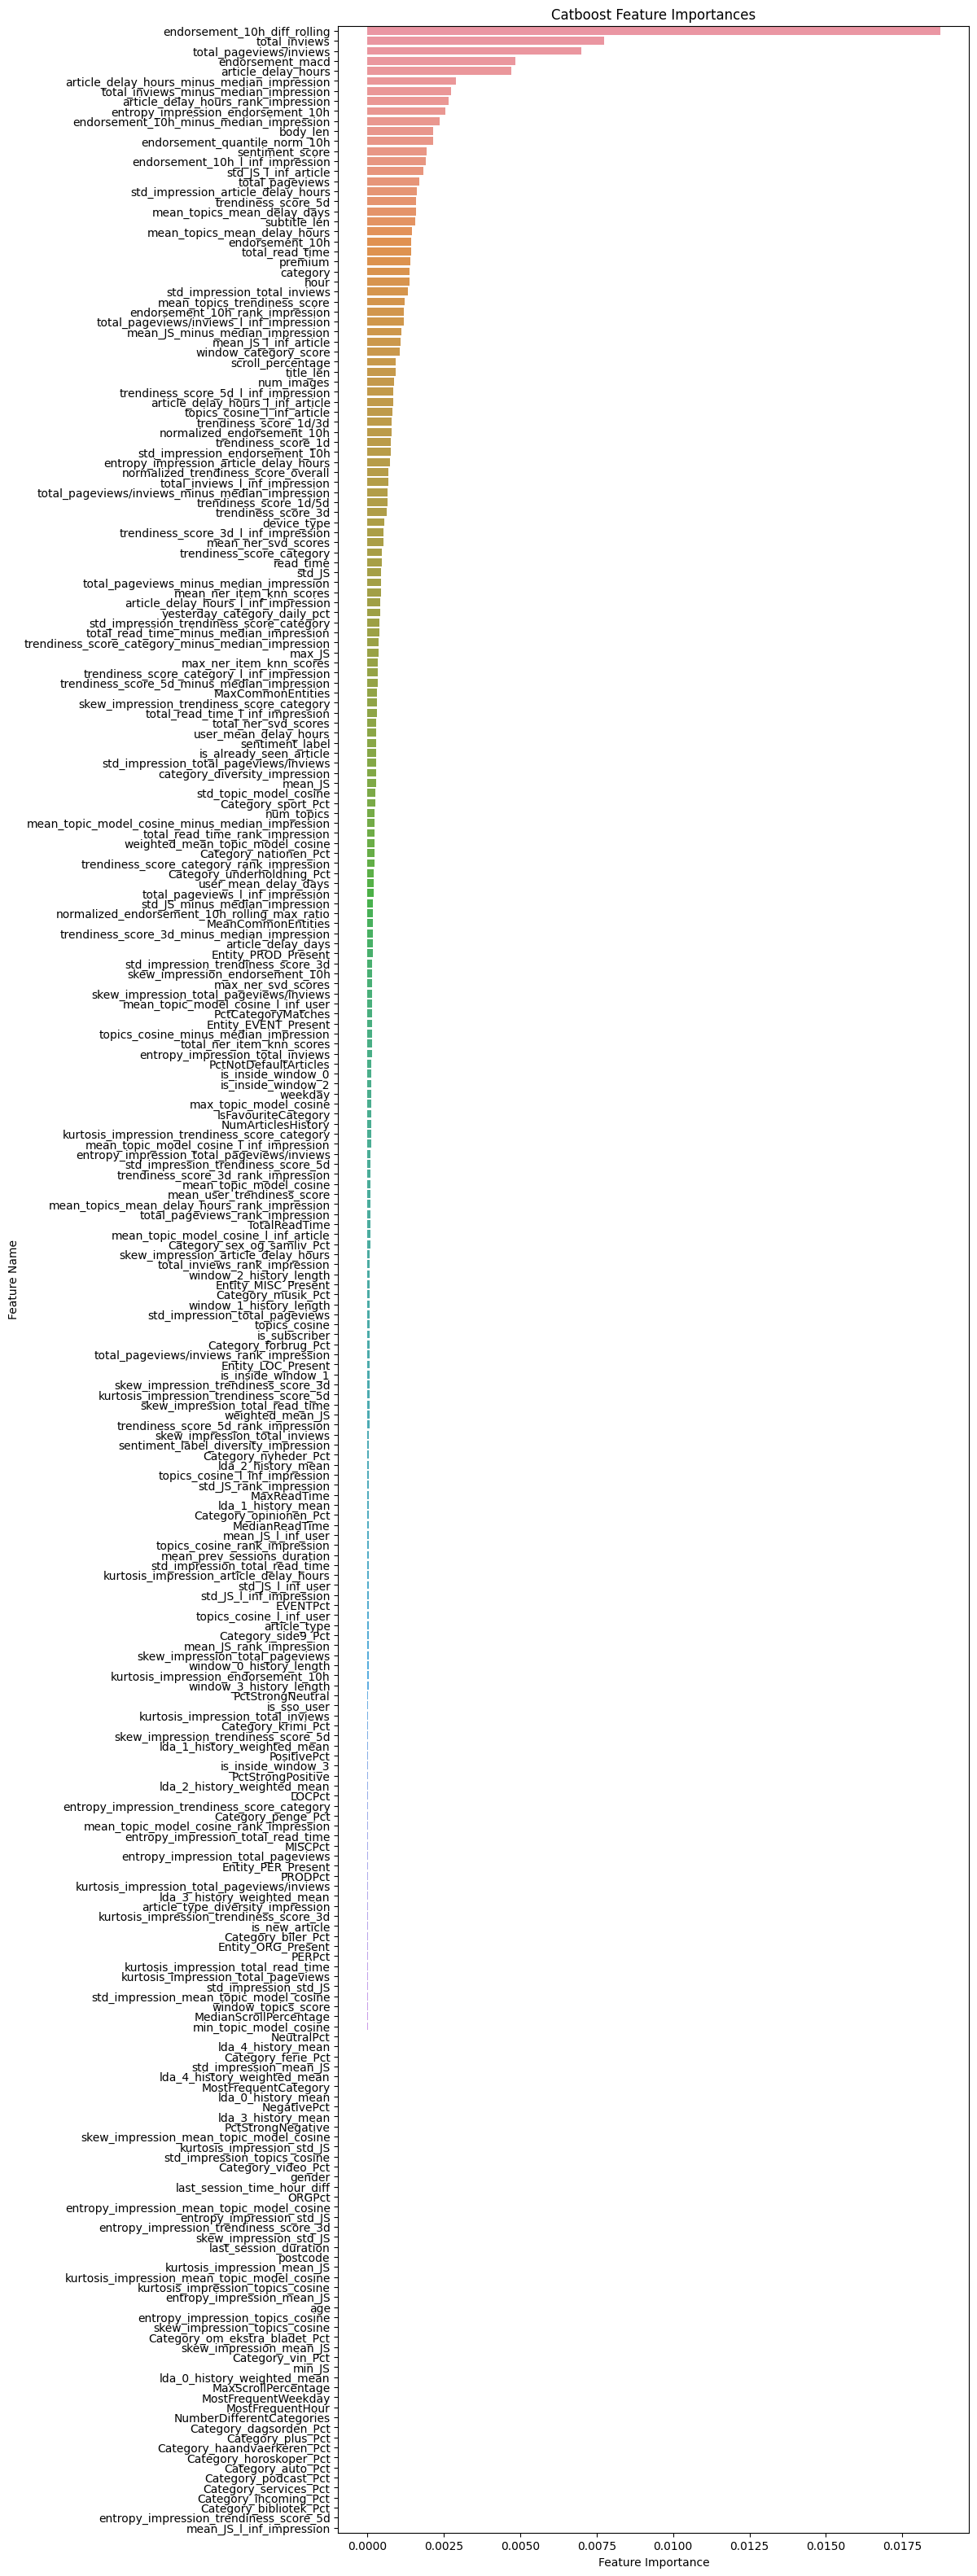

In [42]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 40))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [43]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 11.78


# Model Evaluation

In [44]:
user_id_mapping = history_val.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_interactions = history_val.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_val.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [45]:
item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 19035 (43.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 154.64 column/sec. Elapsed time 4.72 min
EvaluatorHoldout: Ignoring 32 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15310 (100.0%) in 46.46 sec. Users per second: 330


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.338445,0.339461,0.033197,0.241643,0.241977,0.493913,0.346767,0.060464,0.784651,1.033204,...,0.997914,0.783014,0.997914,0.002568,5.473111,0.953841,0.020621,0.428217,3.43338,0.010093


In [46]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 3 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 19035 (43.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.81 sec
EvaluatorHoldout: Processed 15310 (100.0%) in 25.92 sec. Users per second: 591


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.365382,0.368539,0.050795,0.283615,0.285707,0.695447,0.415659,0.089191,0.876486,1.342637,...,0.997914,0.874658,0.997914,0.001527,5.728555,0.954883,0.012263,0.448203,3.536612,0.010003


In [47]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_val.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_val.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).sum().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l_inf normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 4min 40s, sys: 3min 10s, total: 7min 50s
Wall time: 2min 9s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
147688643,9790825,0.037826,0.010083,0.047219,0.044768,0.012257,0.04982
498038614,9783004,0.027961,0.025008,0.046573,0.030671,0.0277,0.039106
499048539,9142564,0.14493,0.075015,0.138363,0.142875,0.07643,0.150293
398897884,9787553,-0.003527,-0.006294,0.000077,0.000535,0.000954,0.00117
534081346,9784696,0.009186,0.021556,0.009847,0.020199,0.044386,0.020998


In [48]:
%%time

STRONG_THR = 0.8

history_val = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_val.iter_slices(1000), total=history_val.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_val = reduce_polars_df_memory_size(history_val)
history_val.head(2)

16it [00:16,  1.03s/it]                        



RAM memory GB usage = 12.51
Memory usage of dataframe is 36.51 MB
Memory usage after optimization is: 35.72 MB
Decreased by 2.2%
CPU times: user 19.8 s, sys: 1.46 s, total: 21.2 s
Wall time: 17.3 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,MISCPct,PRODPct,EVENTPct,PERPct,LOCPct,ORGPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9750749, 9685790, … 9779517]","[2023-05-05 07:51:01, 2023-05-05 07:51:36, … 2023-05-24 17:10:11]","[118, 457, … 414]",150,3.5,1563.0,9330.0,37.0,100.0,0.28,0.093333,0.626667,0.126667,0.06,0.546667,0.06,118,1,20,"[0.0, 0.042172, … 0.089681]",0.266667,0.213333,0.3,0.893333,0.846667,0.913333
12718,"[9749036, 9749025, … 9778718]","[2023-05-04 07:49:49, 2023-05-04 07:50:15, … 2023-05-24 07:07:25]","[118, 118, … 140]",114,7.0,748.0,3440.0,36.0,100.0,0.245614,0.052632,0.701754,0.087719,0.035088,0.614035,0.035088,118,4,7,"[0.0, 0.048524, … 0.217846]",0.192982,0.254386,0.114035,0.807018,0.815789,0.947368


In [49]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration',
              'all_seen_articles', 'mean_prev_sessions_duration'])

In [50]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_val, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_val)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_val, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_val, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)

# dropping duplicates that can occur because of sampling strategy
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .with_columns(pl.col('postcode').fill_null(5)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 
                            'total_pageviews/inviews', 'article_type']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement) \
    .join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
          left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

16it [00:25,  1.60s/it]
2205it [00:05, 405.03it/s]                          
16it [00:01,  9.18it/s]                        
16it [00:02,  7.56it/s]                        
100%|██████████| 507/507 [00:04<00:00, 121.30it/s]



RAM memory GB usage = 13.94
Memory usage of dataframe is 1012.26 MB
Memory usage after optimization is: 592.92 MB
Decreased by 41.4%

RAM memory GB usage = 13.53
CPU times: user 11min 37s, sys: 59.9 s, total: 12min 37s
Wall time: 3min 44s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,Entity_LOC_Present,Entity_ORG_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
488586483,9780815,1528480,2023-05-28,0,1,12.0,null,false,2,null,false,5,53,161,274,1,7,0.329193,0.193431,0.264803,true,414,0.8868,"""Negative""",6,10,19,1127,4,63246,515693,2.941241e6,0.122643,"""article_default""",0,1,…,true,true,0.106844,0.065881,0.094027,0.180837,0.104395,0.139732,263.105621,232.96637,6.433967,157.172226,14.471831,349.823944,235,49,34,5,1,0,0,0,29,97,38,1360,0.016413,45.599998,24.0,0.755556,0.476524,0,0.75,69,false,false,0.115044
461031278,9782180,335666,2023-05-25,1,2,30.0,null,false,2,null,false,5,55,140,202,5,11,0.392857,0.272277,0.286885,false,512,0.7582,"""Positive""",3,6,47,229,3,117148,517249,8.121189e6,0.226483,"""article_default""",0,2,…,true,true,0.000498,0.00097,0.000793,0.001111,0.002096,0.001934,167.057144,273.270813,7.186107,174.970581,19.009523,459.457153,48,36,19,28,1,0,0,0,2,9,15,1608,0.015729,50.900002,30.299999,1.0,0.594675,0,0.0,-33,true,false,0.04878
263751327,9688894,597261,2023-05-30,0,1,15.0,null,false,2,null,false,5,55,113,206,3,6,0.486726,0.26699,0.186469,true,140,0.9897,"""Negative""",3,7,22,631,4,21080,773505,1.234357e6,0.027253,"""article_default""",68,1632,…,true,true,0.108952,0.088805,0.111351,0.108636,0.092441,0.123642,222.511627,170.65889,8.056575,195.93222,0.069767,6.488372,34,13,3,13,1,0,0,0,6,17,43,235,0.002211,20.799999,8.0,0.162405,0.359327,0,7.25,143,true,false,0.153285
450884403,9786204,1602147,2023-05-28,0,1,13.0,null,false,2,null,false,5,38,133,289,1,9,0.285714,0.131488,0.21875,false,118,0.9275,"""Neutral""",1,6,15,177,6,101505,554725,5.864674e6,0.182983,"""article_default""",0,1,…,false,true,0.000014,0.000036,0.000021,0.0,0.0,0.0,200.472733,233.87088,6.733489,164.109512,5.454545,131.436371,41,14,3,2,1,0,0,0,23,25,96,633,0.008899,37.400002,23.200001,0.227126,0.170161,0,0.0,97,false,false,0.309735
488485478,9780482,1524925,2023-05-24,1,2,8.0,null,false,2,null,false,5,54,151,222,4,10,0.357616,0.243243,0.276557,false,118,0.9876,"""Negative""",1,4,17,282,4,127450,589609,7.677861e6,0.21616,"""article_default""",0,1,…,true,true,0.04636,0.062462,0.033934,0.051527,0.069192,0.069438,182.303619,174.438522,3.642022,89.905807,3.206128,78.729805,141,137,79,59,1,0,0,0,77,155,109,860,0.01928,40.299999,22.9,1.077694,0.675039,1,2.45,-78,true,false,0.239437


In [51]:
val_ds.shape

(2928942, 78)

In [52]:
prev_columns = [c for c in val_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

val_ds = pl.concat(
    rows.join(history_val.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_val.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(val_ds.iter_slices(10000), total=val_ds.shape[0] // 10000)
)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

293it [39:31,  8.09s/it]


Memory usage of dataframe is 1783.90 MB
Memory usage after optimization is: 1350.94 MB
Decreased by 24.3%

RAM memory GB usage = 15.76


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,Entity_MISC_Present,…,MostFrequentWeekday,MostFrequentHour,MISCPct,PRODPct,EVENTPct,PERPct,LOCPct,ORGPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_side9_Pct,Category_krimi_Pct,Category_ferie_Pct,Category_bibliotek_Pct,Category_underholdning_Pct,Category_penge_Pct,Category_vin_Pct,Category_dagsorden_Pct,Category_plus_Pct,Category_musik_Pct,Category_haandvaerkeren_Pct,Category_horoskoper_Pct,Category_auto_Pct,Category_forbrug_Pct,Category_podcast_Pct,Category_nyheder_Pct,Category_om_ekstra_bladet_Pct,Category_services_Pct,Category_biler_Pct,Category_sport_Pct,Category_incoming_Pct,Category_opinionen_Pct,Category_video_Pct,Category_nationen_Pct,Category_sex_og_samliv_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
48784165,9788323,890497,0,1,25.0,null,true,0,null,true,5,168,529,855,3,20,0.31758,0.196491,0.872937,false,142,0.9076,"""Positive""",2,4,18,241,5,32013,219718,2.639459e6,0.1457,"""article_default""",1,32,false,…,1,5,0.255187,0.192946,0.298755,0.912863,0.809129,0.93361,0.747894,true,9,0.983402,0.0,0.128631,0.0,0.0,0.047718,0.051867,0.0,0.0,0.0,0.002075,0.0,0.0,0.0,0.020747,0.0,0.323651,0.0,0.0,0.0,0.381743,0.0,0.0,0.0,0.039419,0.004149
447883136,9783278,739117,0,2,91.0,null,false,2,null,false,5,1,12,19,2,16,0.083333,0.052632,0.019017,false,414,0.9835,"""Negative""",4,7,16,453,2,193114,726487,1.4334198e7,0.265819,"""article_default""",3,91,false,…,3,9,0.5,0.642857,0.357143,0.857143,0.5,0.928571,0.0,false,6,0.642857,0.0,0.214286,0.0,0.0,0.071429,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0
14557521,9781389,707180,0,1,25.0,null,false,2,null,false,5,36,92,139,4,21,0.391304,0.258993,0.168498,false,512,0.9499,"""Negative""",3,6,28,408,3,164181,628848,1.2768224e7,0.261082,"""article_default""",0,2,false,…,1,10,0.0,0.0,0.333333,1.0,0.833333,1.0,0.120921,false,4,0.333333,0.0,0.166667,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
242118167,9769917,302666,0,2,16.0,null,false,2,null,false,5,34,59,114,3,20,0.576271,0.298246,0.09736,true,140,0.989,"""Negative""",4,5,32,826,2,203222,2163455,1.2661448e7,0.093934,"""article_default""",14,340,false,…,5,6,0.248705,0.176166,0.170984,0.834197,0.777202,0.854922,0.254556,false,10,0.953368,0.196891,0.129534,0.0,0.0,0.124352,0.015544,0.0,0.0,0.0,0.005181,0.0,0.0,0.0,0.005181,0.0,0.409326,0.0,0.0,0.0,0.093264,0.0,0.0,0.0,0.005181,0.015544
461858103,9786288,2084690,1,1,26.0,null,false,2,null,false,5,50,137,270,1,15,0.364964,0.185185,0.225329,false,2975,0.9534,"""Negative""",1,6,12,212,4,181533,700398,9.265666e6,0.259185,"""article_default""",0,6,false,…,7,15,0.226667,0.333333,0.186667,0.94,0.8,0.98,0.228029,false,6,0.966667,0.0,0.186667,0.0,0.0,0.306667,0.026667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326667,0.0,0.0,0.0,0.053333,0.0,0.0,0.0,0.1,0.0


In [53]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'article_delay_hours', 'total_pageviews',
    'total_inviews', 'trendiness_score_category', 'std_JS', 'trendiness_score_5d', 'total_read_time'
]
RANK_IMPRESSION_DESCENDING = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'total_pageviews', 'total_read_time',
    'total_inviews', 'trendiness_score_category', 'trendiness_score_5d'
]
RANK_IMPRESSION_ASCENDING = [
    'article_delay_hours', 'std_JS', 'mean_topics_mean_delay_hours'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
LIST_DIVERSITY = [
    'category', 'sentiment_label', 'article_type'
]

val_ds = val_ds.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).rank(method='min').over(pl.col('impression_id')).alias(f'{c}_rank_impression')
      for c in RANK_IMPRESSION_ASCENDING],
    *[pl.col(c).rank(method='min', descending=True).over(pl.col('impression_id')).alias(f'{c}_rank_impression')
      for c in RANK_IMPRESSION_DESCENDING],
    *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).entropy().over(pl.col('impression_id')).alias(f'entropy_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) - pl.col(c).median().over(pl.col('impression_id'))).alias(f'{c}_minus_median_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
      for c in NORMALIZE_OVER_USER_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
      for c in NORMALIZE_OVER_ARTICLE],
    *[pl.col(c).n_unique().over('impression_id').alias(f'{c}_diversity_impression')
      for c in LIST_DIVERSITY],
)

In [54]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [55]:
val_ds.shape

(2928942, 254)

In [56]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'article_type',
 'postcode',
 'Entity_MISC_Present',
 'Entity_PROD_Present',
 'Entity_EVENT_Present',
 'Entity_PER_Present',
 'Entity_LOC_Present',
 'Entity_ORG_Present']

In [57]:
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

val_ds = val_ds.with_columns(pl.Series(model.predict(X_val)).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
48784165,0,0.884504
447883136,0,2.159811
14557521,0,1.368329
242118167,0,0.363505
461858103,1,2.563236
…,…,…
68649147,0,-1.739144
251493443,0,0.749647
299192384,0,-2.247563


In [58]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
393036409,"[0, 0, … 0]","[-1.45534, 1.332194, … -1.829128]"
196131171,"[0, 0, … 1]","[1.589098, -0.856062, … 2.131225]"
46550577,"[0, 0, … 0]","[0.61223, -0.08192, … -0.595724]"
273711995,"[0, 0, … 0]","[0.053893, -1.342687, … 0.899099]"
46791993,"[0, 0, … 0]","[-0.679044, -1.281854, … 1.736854]"
…,…,…
40285889,"[0, 0, … 0]","[1.41724, 0.858153, … -0.341275]"
386101242,"[0, 0, … 0]","[-0.828727, 3.596285, … 3.195308]"
511687937,"[1, 0, … 0]","[0.758401, -3.310468, … 0.943494]"


In [59]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 8min 13s, sys: 482 ms, total: 8min 14s
Wall time: 8min 14s


<MetricEvaluator class>: 
 {
    "auc": 0.7943901677272932,
    "mrr": 0.5839511477062487,
    "ndcg@5": 0.6496021523729745,
    "ndcg@10": 0.6754032244253373
}